<a href="https://colab.research.google.com/github/hubert78/Nobel-Price-Winners/blob/main/Cat_or_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

**Getting the dataset from Kaggle**

In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Kaggle api
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
ls

cat-and-dog.zip  kaggle.json  sample_data/  test_set/  training_set/


In [ ]:
# extracting the compressed dataset
from zipfile import ZipFile

file_path = '/content/cat-and-dog.zip'

with ZipFile(file_path, 'r') as file:
  file.extractall()
  print('The dataset is extracted')

The dataset is extracted


**Global variables**

In [ ]:
image_size = 224
num_categories = 2

**Get the file path**

In [ ]:
test_dir_path = '/content/test_set/test_set'
train_dir_path = '/content/training_set/training_set'

train_dir_path, test_dir_path

('/content/training_set/training_set', '/content/test_set/test_set')

In [ ]:
path, dirs, files = next(os.walk(train_dir_path))
print(path)
print(dirs)
print(files)

/content/training_set/training_set
['cats', 'dogs']
[]


**Function to extract the images and their labels from the file path**

In [ ]:
# Function to get images and their labels

def get_images(animals, dir_path):
  images = []
  labels = []

  for i, animal in enumerate(animals):
      path = os.path.join(dir_path, animal)
      for img in os.listdir(path):
          img_array = cv2.imread(os.path.join(path, img))

          #Checking if the file is indeed an image
          if img_array is not None:
            img_array = cv2.resize(img_array, (image_size, image_size))
            images.append(img_array)
            labels.append(i)
          else:
            continue
  images = np.array(images)
  labels = np.array(labels)

  return images, labels

In [ ]:
# Getting the training images and their labels
train_images, train_labels = get_images(dirs, train_dir_path)

In [ ]:
print('Image shape = ', train_images.shape)

print('First Label = ', train_labels[:5])
print('File length = ', train_labels.shape)

Image shape =  (8005, 224, 224, 3)
First Label =  [0 0 0 0 0]
File length =  (8005,)


In [ ]:
# Getting the training images and their labels
test_images, test_labels = get_images(dirs, test_dir_path)

In [ ]:
print('Image shape = ', test_images.shape)

print('First Label = ', test_labels[:5])
print('File length = ', test_labels.shape)

Image shape =  (2023, 224, 224, 3)
First Label =  [0 0 0 0 0]
File length =  (2023,)


**Visualizing the Images**

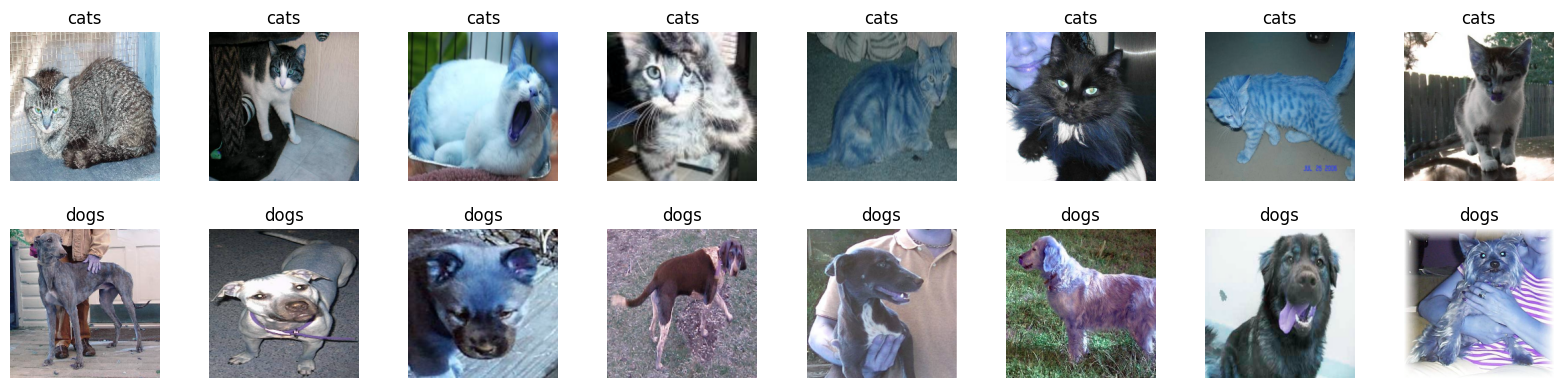

In [ ]:
category_images = {i: [] for i in range(num_categories)}

# Populate the dictionary with images categorized by their label
for img, label in zip(train_images, train_labels):
    category_images[label].append(img)

# Determine the number of images and subplots needed
num_plots = num_categories * 8
rows = num_categories
cols = 8

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
fig.tight_layout(pad=0.5)

for i in range(rows):
    for j in range(cols):
        ax = axes[i, j] if cols > 1 else axes[i]
        if j < len(category_images[i]):
            # Display the image
            ax.imshow(category_images[i][j])
            # Display the label above the image
            ax.set_title(dirs[i])
        ax.set_axis_off()

# Show the plot
plt.show()

## **Creating a CNN model**

In [ ]:
# Transforming the labels into a one_hot encoded values
Y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_categories)
Y_test = tf.keras.utils.to_categorical(test_labels, num_classes=num_categories)


In [ ]:
# Normalizing the images
X_train = train_images / 255
X_test = test_images / 255

In [ ]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)),

    # First convolutional layer with 32 filters
    Conv2D(64, (3, 3), activation="relu"),

    # Second convolutional layer with 32 filters
    Conv2D(64, (3, 3), activation="relu"),

    # Max pooling layer with 2x2 pool size
    MaxPooling2D(pool_size=(2, 2)),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten units
    Flatten(),

    # Fully connected layer with 128 units and dropout
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dropout(0.5),

    # Output layer with softmax activation for classification
    Dense(num_categories, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=["acc"]
)

In [ ]:
model.fit(X_train, Y_train, epochs=5)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - acc: 0.5107 - loss: 0.7817
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - acc: 0.5782 - loss: 0.6834
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 536s 2s/step - acc: 0.6758 - loss: 0.6201
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - acc: 0.7908 - loss: 0.4662
Epoch 5/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - acc: 0.8904 - loss: 0.2947


**Model Evaluation**

In [ ]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
test_loss, test_acc


64/64 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - acc: 0.6804 - loss: 0.9063


(0.97877037525177, 0.663371205329895)

In [ ]:
# Converting labels from one-hot encoded to integers
Y_train_int = np.argmax(Y_train, axis=1)
Y_test_int = np.argmax(Y_test, axis=1)


y_pred = model.predict(X_test)
Y_pred_int = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(Y_test_int, Y_pred_int, target_names=dirs)
report

64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step


'              precision    recall  f1-score   support\n\n        cats       0.66      0.68      0.67      1011\n        dogs       0.67      0.65      0.66      1012\n\n    accuracy                           0.66      2023\n   macro avg       0.66      0.66      0.66      2023\nweighted avg       0.66      0.66      0.66      2023\n'

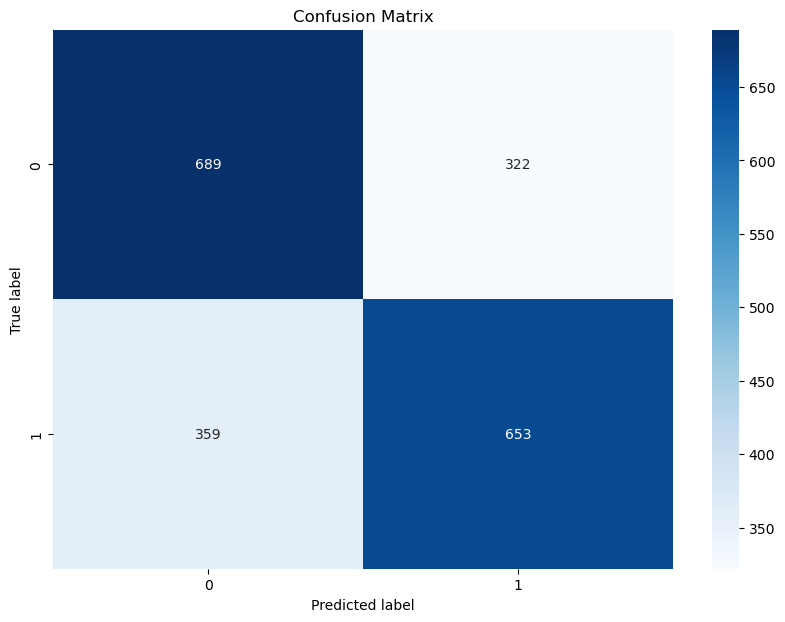

In [ ]:
cm = confusion_matrix(Y_test_int, Y_pred_int)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Using a Pretrained Model

**Creating a function to sample part of the images for our pretrained model**

In [ ]:
def sampler(imgs, labels, number=1000):
  cat_count = 0
  dog_count = 0

  img_train = []
  label_train = []

  for img, label in zip(imgs, labels):
    if cat_count >= number and dog_count >= number:
      break

    if cat_count < number and label == 0:
      img_train.append(img)
      label_train.append(label)
      cat_count += 1

    elif dog_count < number and label == 1:
      img_train.append(img)
      label_train.append(label)
      dog_count +=1

  img_train = np.array(img_train)/255
  label_train = np.array(label_train)

  return img_train, label_train


In [ ]:
p_X_train, p_Y_train = sampler(train_images, train_labels, 800)

In [ ]:
print(p_X_train.shape)
print(p_Y_train.shape)

(1600, 224, 224, 3)
(1600,)
[0 1]
[0 1]


In [ ]:
p_X_test, p_Y_test = sampler(test_images, test_labels, 200)

In [ ]:
print(p_X_test.shape)
print(p_Y_test.shape)

(400, 224, 224, 3)
(400,)


**Importing the pretrained model**

In [ ]:
mobilenet_model_path = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model = hub.KerasLayer(mobilenet_model_path, input_shape=(image_size, image_size, 3), trainable=False)

In [ ]:
model = tf.keras.Sequential([

    pretrained_model,
    tf.keras.layers.Dense(num_categories)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [ ]:
model.fit(p_X_train, p_Y_train, epochs=5)

Epoch 1/5
50/50 [==============================] - 59s 1s/step - loss: 0.1769 - acc: 0.9287
Epoch 2/5
50/50 [==============================] - 54s 1s/step - loss: 0.0551 - acc: 0.9819
Epoch 3/5
50/50 [==============================] - 59s 1s/step - loss: 0.0416 - acc: 0.9881
Epoch 4/5
50/50 [==============================] - 54s 1s/step - loss: 0.0292 - acc: 0.9937
Epoch 5/5
50/50 [==============================] - 59s 1s/step - loss: 0.0236 - acc: 0.9950


**Evaluate the model**

In [ ]:
model.evaluate(p_X_test, p_Y_test)

13/13 [==============================] - 17s 1s/step - loss: 0.0461 - acc: 0.9800


[0.04607543349266052, 0.9800000190734863]